# Final Model Development and Training

In this Jupyter Notebook, you will develop and train the model for the final model (chosen from 'notebook - prototype' jupyter notebook).

**The content in this notebook will be used to make the recommendation system work in the StreamLit front-end (tentative).**

As stated in 'notebook - prototype' jupyter notebook, the optimal choice (for now) will be the KMeans model.

#### Recommendation A/B Testing: Experimentation with Imperfect Compliance

An online business would like to test a new feature or offering of their website and learn its effect on downstream revenue. Furthermore, they would like to know which kind of users respond best to the new version. We call the user-specfic effect a **heterogeneous treatment effect**. 

Ideally, the business would run an A/B tests between the old and new versions of the website. However, a direct A/B test might not work because the business cannot force the customers to take the new offering. Measuring the effect in this way will be misleading since not every customer exposed to the new offering will take it.

The business also cannot look directly at existing data as it will be biased: the users who use the latest website features are most likely the ones who are very engaged on the website and hence spend more on the company's products to begin with. Estimating the effect this way would be overly optimistic.

**tools from the [EconML](https://aka.ms/econml) library can still use a direct A/B test and mitigate these shortcomings.**

For A/B Testing, source: https://github.com/py-why/EconML/blob/main/notebooks/CustomerScenarios/Case%20Study%20-%20Recommendation%20AB%20Testing%20at%20An%20Online%20Travel%20Company.ipynb

NOTE: EconML only works if you downgrade the python version to 3.10.

Locally, I have changed the kernel environment to .conda (Python 3.10.16)

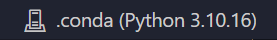

In [1]:
  # !pip install pandas psycopg2 scikit-learn torch missingno seaborn matplotlib econml

In [2]:
### Importing...
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2 as ps
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import missingno as msno
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# EconML imports
from econml.iv.dr import LinearIntentToTreatDRIV
from econml.cate_interpreter import SingleTreeCateInterpreter, \
                                    SingleTreePolicyInterpreter


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Grabbing the Data and Cleaning it to merged_df

#### Connecting PostGreSQL database

Note: run docker before running the following codes, or tlse it wont work

In [3]:
# reads the whole API
conn2 = ps.connect(dbname = "postgres",
                   user = "postgres",
                   password = "postgres",
                   host = "localhost",
                   port = "5432")

In [4]:
# connect area table
area_sql = """select * 
fROM public.area"""

# connect farm table
farm_sql = """select * 
fROM public.farm"""

# connect product table
product_sql = """select * 
fROM public.product"""

# connect sale_order table
so_sql = """select * 
fROM public.sale_order"""

# connect sale_order_item table
soi_sql = """select * 
fROM public.sale_order_item"""

# connect feedback table
feedback_sql = """select *
fROM public.feedback"""

# connect product_clicks table
product_clicks_sql = """select *
fROM public.product_clicks"""

# connect user_session table
user_session_sql = """select *
fROM public.user_session"""

In [5]:
# read area table
area_df = sqlio.read_sql_query(area_sql, conn2)

# read farm table
farm_df = sqlio.read_sql_query(farm_sql, conn2)

# read product table
product_df = sqlio.read_sql_query(product_sql, conn2)

# read sale_order table
so_df = sqlio.read_sql_query(so_sql, conn2)

# read sale_order_item table
soi_df = sqlio.read_sql_query(soi_sql, conn2)

# read feedback table
feedback_df = sqlio.read_sql_query(feedback_sql, conn2)

# read product_clicks table
product_clicks_df = sqlio.read_sql_query(product_clicks_sql, conn2)

# read user_session table
user_session_df = sqlio.read_sql_query(user_session_sql, conn2)

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
pandas only supports SQLAlchemy connectable (engine/connecti

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

### Renaming of columns for easier interpretability

In [7]:
# rename product_df columns
product_df.rename(columns={'id': 'product_id', 'price': 'product_price'}, inplace=True)
product_df.columns

Index(['product_id', 'sku', 'type', 'unit_of_measurement', 'name',
       'product_price', 'description'],
      dtype='object')

In [8]:
# rename soi_df columns
soi_df.rename(columns={'id': 'sale_order_item_id', 'price': 'sale_order_item_price'}, inplace=True)
soi_df.columns

Index(['sale_order_item_id', 'sale_order_id', 'product_id', 'quantity',
       'sale_order_item_price', 'clicked_from_recommendation',
       'click_timestamp'],
      dtype='object')

In [9]:
# rename so_df columns
so_df.rename(columns={'id': 'sale_order_id'}, inplace=True)
so_df.columns

Index(['sale_order_id', 'user_id', 'total_item_price', 'created_at_utc0'], dtype='object')

### Merging of Dataframes

In [10]:
merged_data = soi_df.merge(so_df, on='sale_order_id')
merged_data.head()

,sale_order_item_id,sale_order_id,product_id,quantity,sale_order_item_price,clicked_from_recommendation,click_timestamp,user_id,total_item_price,created_at_utc0
0,7eefa7db-26bf-4a8b-b207-f44a52ed0aba,3ddca641-cb59-4a27-8698-cb16ff2932f2,b53ce31c-3789-42d7-96a0-5fe058cac7a5,200,125000.0,False,NaT,13f5223e-f04a-4fa8-9ef2-cf36060f0d6d,90200000.0,1744078798583
1,e9b32dc3-4e0f-4a69-bb3d-c7f11277f97f,787bc8b7-e679-4772-be5d-af4afac9adf5,5952d124-7dc6-4a6a-baa2-e2e502ecd6fe,1,109000.0,False,NaT,1e75f22f-b609-4ebc-9536-4a26aef73302,109000.0,1744182202966
2,86a41dec-9936-4c8f-9150-e8b367a4959f,4d47dd32-1618-4376-a846-66bcf065e173,0bd2430a-6613-442a-9d5a-11d64cb095ae,1,65000.0,False,NaT,344963f8-9a3a-4de3-b3a9-c8716fa37c0e,65000.0,1742438712361
3,61cf5f3f-2a24-4080-bc4f-50af3506479d,e5819416-6b56-4337-9271-dc2c701ac7bd,80957603-6cec-4f63-8dcd-aba6ded5cbdd,2,688750.0,False,NaT,49ad56f8-8d32-408f-9f88-36cad5310680,1377500.0,1744874598061
4,4ebafa85-bc91-4685-9775-3cc06be3f4b6,a1688ca7-4123-4d2a-8ef4-44a0be1580a1,6c27fc9c-e7e9-4e9b-9017-292175250df1,90,219125.0,False,NaT,41bec98e-b466-496b-acf2-e993389ac42b,19721250.0,1742714745447


In [11]:
merged_data = merged_data.merge(product_df, on='product_id')
merged_data.head()

,sale_order_item_id,sale_order_id,product_id,quantity,sale_order_item_price,clicked_from_recommendation,click_timestamp,user_id,total_item_price,created_at_utc0,sku,type,unit_of_measurement,name,product_price,description
0,7eefa7db-26bf-4a8b-b207-f44a52ed0aba,3ddca641-cb59-4a27-8698-cb16ff2932f2,b53ce31c-3789-42d7-96a0-5fe058cac7a5,200,125000.0,False,NaT,13f5223e-f04a-4fa8-9ef2-cf36060f0d6d,90200000.0,1744078798583,101110502101,GOODS,kg,RP Mahkota 50kg - Egypt,352688.0,"Rock Phosphate (RP) adalah salah satu sumber fosfat terbaik di dunia yang diolah secara efisien tanpa proses kimia. <p><strong>Deskripsi</strong></p><p><br></p><p>Pupuk RP Mesir adalah pupuk yang diproses dari bahan baku galian yang mengandung mineral kalsium fosfat, yang berasal dari batuan yang diolah menjadi bubuk (powder) untuk digunakan langsung dalam pertanian. Pupuk ini dapat diterapkan dalam bentuk bubuk, butiran, atau granular.</p><p><br></p><p><strong>Manfaat</strong></p><p><br></p><p>Memberikan unsur fosfor alami yang dibutuhkan tanaman, mendukung perkembangan akar dan batang, meningkatkan kualitas akar serta batang tanaman, memperbaiki kemampuan tanaman dalam menyerap air dan nutrisi, serta melindungi tanaman dari serangan hama.</p><p><br></p><p><strong>Kandungan dan Spesifikasi</strong></p><p><br></p><p>Fosfor pentoksida 26-28%</p><p><br></p><p><strong>Produk Teruji Lab?</strong> Ya</p>"
1,e9b32dc3-4e0f-4a69-bb3d-c7f11277f97f,787bc8b7-e679-4772-be5d-af4afac9adf5,5952d124-7dc6-4a6a-baa2-e2e502ecd6fe,1,109000.0,False,NaT,1e75f22f-b609-4ebc-9536-4a26aef73302,109000.0,1744182202966,TUP/PLN/100,DIGITAL,,Token PLN 100.000,109000.0,Topup PLN 100.000 Topup PLN 100.000
2,86a41dec-9936-4c8f-9150-e8b367a4959f,4d47dd32-1618-4376-a846-66bcf065e173,0bd2430a-6613-442a-9d5a-11d64cb095ae,1,65000.0,False,NaT,344963f8-9a3a-4de3-b3a9-c8716fa37c0e,65000.0,1742438712361,MERCH-SAWITPRO-SHIRT-02,GOODS,kg,Kaos SIBRONDOL SawitPRO size XL,100000.0,"<p>Kaos tidak berkerah warna Putih bertuliskan ""Sibrondol SawitPRO"".</p><p>Ukuran All-size (XL)</p>"
3,61cf5f3f-2a24-4080-bc4f-50af3506479d,e5819416-6b56-4337-9271-dc2c701ac7bd,80957603-6cec-4f63-8dcd-aba6ded5cbdd,2,688750.0,False,NaT,49ad56f8-8d32-408f-9f88-36cad5310680,1377500.0,1744874598061,101110501601,GOODS,kg,MOP/KCL Canada Cap Mahkota 50kg,712500.0,"Pupuk MOP/KCL untuk meningkatkan Kualitas dan Kuantitas Buah. <p><strong><em><u>Deskripsi</u></em></strong></p><p><br></p><p>Pupuk MOP/KCL Mahkota mengandung kalium (K2O) minimal 60% dan berguna untuk membantu meningkatkan hasil dan kualitas panen. Pupuk ini juga mengoptimalkan penyerapan unsur hara lainnya dan meningkatkan ketahanan tanaman terhadap hama dan penyakit. Penggunaan KCL sangat penting untuk tanaman tahunan yang membutuhkan kalium tinggi.</p><p><br></p><p><strong><em><u>Manfaat </u></em></strong></p><p>Pupuk kalium oksida (K2O) meningkatkan pertumbuhan dan hasil tanaman dengan menyuplai kalium yang penting untuk daya tahan tanaman terhadap stres, serta mendukung pembentukan buah, bunga, dan umbi. Pupuk ini juga memperbaiki kualitas hasil panen dan efisiensi penggunaan air serta nutrisi, menjadikannya bermanfaat untuk tanaman yang membutuhkan kalium tinggi, seperti padi, jagung, dan tanaman hortikultura.</p><p><br></p><p><strong><em><u>Kandungan dan Spesifikasi </u></em></strong></p><p><br></p><p>Kalium oksida 60%</p><p>Bentuk / Warna: Kristal / Dominan merah</p><p><br></p><p><strong><em><u>Produk Teruji Lab?</u> </em></strong>Ya</p>"
4,4ebafa85-bc91-4685-9775-3cc06be3f4b6,a1688ca7-4123-4d2a-8ef4-44a0be1580a1,6c27fc9c-e7e9-4e9b-9017-292175250df1,90,219125.0,False,NaT,41bec98e-b466-496b-acf2-e993389ac42b,19721250.0,1742714745447,101110603901,GOODS,kg,NPK Phonska Plus 15-15-15 25kg,441142.0,"Tingkatkan pertumbuhan dengan zinc 2000ppm dan sulfur 9%. <p><strong><em><u>Deskripsi</u></em></strong></p><p><br></p><p>Pupuk majemuk NPK yang diperkaya dengan unsur sulfur dan zinc ini dirancang untuk meningkatkan efisiensi dan efektivitas pemupukan. Kandungan sulfur dan zinc 

In [12]:
def clean_html(raw_html):
    # Remove HTML tags
    clean_text = re.sub(r'<[^>]+>', '', raw_html)
    # Remove leading/trailing whitespaces and normalize spaces
    clean_text = re.sub(r'\s+', ' ', clean_text).strip()
    return clean_text

# Apply to the 'description' column
merged_data['description'] = merged_data['description'].astype(str).apply(clean_html)

# Preview the cleaned descriptions
merged_data[['description']].head()


,description
0,"Rock Phosphate (RP) adalah salah satu sumber fosfat terbaik di dunia yang diolah secara efisien tanpa proses kimia. DeskripsiPupuk RP Mesir adalah pupuk yang diproses dari bahan baku galian yang mengandung mineral kalsium fosfat, yang berasal dari batuan yang diolah menjadi bubuk (powder) untuk digunakan langsung dalam pertanian. Pupuk ini dapat diterapkan dalam bentuk bubuk, butiran, atau granular.ManfaatMemberikan unsur fosfor alami yang dibutuhkan tanaman, mendukung perkembangan akar dan batang, meningkatkan kualitas akar serta batang tanaman, memperbaiki kemampuan tanaman dalam menyerap air dan nutrisi, serta melindungi tanaman dari serangan hama.Kandungan dan SpesifikasiFosfor pentoksida 26-28%Produk Teruji Lab? Ya"
1,Topup PLN 100.000 Topup PLN 100.000
2,"Kaos tidak berkerah warna Putih bertuliskan ""Sibrondol SawitPRO"".Ukuran All-size (XL)"
3,"Pupuk MOP/KCL untuk meningkatkan Kualitas dan Kuantitas Buah. DeskripsiPupuk MOP/KCL Mahkota mengandung kalium (K2O) minimal 60% dan berguna untuk membantu meningkatkan hasil dan kualitas panen. Pupuk ini juga mengoptimalkan penyerapan unsur hara lainnya dan meningkatkan ketahanan tanaman terhadap hama dan penyakit. Penggunaan KCL sangat penting untuk tanaman tahunan yang membutuhkan kalium tinggi.Manfaat Pupuk kalium oksida (K2O) meningkatkan pertumbuhan dan hasil tanaman dengan menyuplai kalium yang penting untuk daya tahan tanaman terhadap stres, serta mendukung pembentukan buah, bunga, dan umbi. Pupuk ini juga memperbaiki kualitas hasil panen dan efisiensi penggunaan air serta nutrisi, menjadikannya bermanfaat untuk tanaman yang membutuhkan kalium tinggi, seperti padi, jagung, dan tanaman hortikultura.Kandungan dan Spesifikasi Kalium oksida 60%Bentuk / Warna: Kristal / Dominan merahProduk Teruji Lab? Ya"
4,"Tingkatkan pertumbuhan dengan zinc 2000ppm dan sulfur 9%. DeskripsiPupuk majemuk NPK yang diperkaya dengan unsur sulfur dan zinc ini dirancang untuk meningkatkan efisiensi dan efektivitas pemupukan. Kandungan sulfur dan zinc tersebut mendukung proses metabolisme tanaman sehingga tidak hanya meningkatkan jumlah hasil panen, tetapi juga kualitasnya, membuat tanaman lebih sehat dan produktif.Bentuk / Warna: Granul / PutihManfaatPupuk ini mendukung pertumbuhan tanaman, meningkatkan hasil, dan kualitas tanaman dengan memperkuat metabolisme, pembelahan sel, serta pembentukan enzim dan vitamin. Selain itu, juga merangsang pertumbuhan akar dan daun serta meningkatkan imunitas tanaman.Kandungan dan SpesifikasiNitrogen 15%Fosfor pentoksida 15%Kalium 15%Sulfur 9%Zinc 0,2%Produk Teruji Lab? Ya"


In [13]:
merged_data.head()


,sale_order_item_id,sale_order_id,product_id,quantity,sale_order_item_price,clicked_from_recommendation,click_timestamp,user_id,total_item_price,created_at_utc0,sku,type,unit_of_measurement,name,product_price,description
0,7eefa7db-26bf-4a8b-b207-f44a52ed0aba,3ddca641-cb59-4a27-8698-cb16ff2932f2,b53ce31c-3789-42d7-96a0-5fe058cac7a5,200,125000.0,False,NaT,13f5223e-f04a-4fa8-9ef2-cf36060f0d6d,90200000.0,1744078798583,101110502101,GOODS,kg,RP Mahkota 50kg - Egypt,352688.0,"Rock Phosphate (RP) adalah salah satu sumber fosfat terbaik di dunia yang diolah secara efisien tanpa proses kimia. DeskripsiPupuk RP Mesir adalah pupuk yang diproses dari bahan baku galian yang mengandung mineral kalsium fosfat, yang berasal dari batuan yang diolah menjadi bubuk (powder) untuk digunakan langsung dalam pertanian. Pupuk ini dapat diterapkan dalam bentuk bubuk, butiran, atau granular.ManfaatMemberikan unsur fosfor alami yang dibutuhkan tanaman, mendukung perkembangan akar dan batang, meningkatkan kualitas akar serta batang tanaman, memperbaiki kemampuan tanaman dalam menyerap air dan nutrisi, serta melindungi tanaman dari serangan hama.Kandungan dan SpesifikasiFosfor pentoksida 26-28%Produk Teruji Lab? Ya"
1,e9b32dc3-4e0f-4a69-bb3d-c7f11277f97f,787bc8b7-e679-4772-be5d-af4afac9adf5,5952d124-7dc6-4a6a-baa2-e2e502ecd6fe,1,109000.0,False,NaT,1e75f22f-b609-4ebc-9536-4a26aef73302,109000.0,1744182202966,TUP/PLN/100,DIGITAL,,Token PLN 100.000,109000.0,Topup PLN 100.000 Topup PLN 100.000
2,86a41dec-9936-4c8f-9150-e8b367a4959f,4d47dd32-1618-4376-a846-66bcf065e173,0bd2430a-6613-442a-9d5a-11d64cb095ae,1,65000.0,False,NaT,344963f8-9a3a-4de3-b3a9-c8716fa37c0e,65000.0,1742438712361,MERCH-SAWITPRO-SHIRT-02,GOODS,kg,Kaos SIBRONDOL SawitPRO size XL,100000.0,"Kaos tidak berkerah warna Putih bertuliskan ""Sibrondol SawitPRO"".Ukuran All-size (XL)"
3,61cf5f3f-2a24-4080-bc4f-50af3506479d,e5819416-6b56-4337-9271-dc2c701ac7bd,80957603-6cec-4f63-8dcd-aba6ded5cbdd,2,688750.0,False,NaT,49ad56f8-8d32-408f-9f88-36cad5310680,1377500.0,1744874598061,101110501601,GOODS,kg,MOP/KCL Canada Cap Mahkota 50kg,712500.0,"Pupuk MOP/KCL untuk meningkatkan Kualitas dan Kuantitas Buah. DeskripsiPupuk MOP/KCL Mahkota mengandung kalium (K2O) minimal 60% dan berguna untuk membantu meningkatkan hasil dan kualitas panen. Pupuk ini juga mengoptimalkan penyerapan unsur hara lainnya dan meningkatkan ketahanan tanaman terhadap hama dan penyakit. Penggunaan KCL sangat penting untuk tanaman tahunan yang membutuhkan kalium tinggi.Manfaat Pupuk kalium oksida (K2O) meningkatkan pertumbuhan dan hasil tanaman dengan menyuplai kalium yang penting untuk daya tahan tanaman terhadap stres, serta mendukung pembentukan buah, bunga, dan umbi. Pupuk ini juga memperbaiki kualitas hasil panen dan efisiensi penggunaan air serta nutrisi, menjadikannya bermanfaat untuk tanaman yang membutuhkan kalium tinggi, seperti padi, jagung, dan tanaman hortikultura.Kandungan dan Spesifikasi Kalium oksida 60%Bentuk / Warna: Kristal / Dominan merahProduk Teruji Lab? Ya"
4,4ebafa85-bc91-4685-9775-3cc06be3f4b6,a1688ca7-4123-4d2a-8ef4-44a0be1580a1,6c27fc9c-e7e9-4e9b-9017-292175250df1,90,219125.0,False,NaT,41bec98e-b466-496b-acf2-e993389ac42b,19721250.0,1742714745447,101110603901,GOODS,kg,NPK Phonska Plus 15-15-15 25kg,441142.0,"Tingkatkan pertumbuhan dengan zinc 2000ppm dan sulfur 9%. DeskripsiPupuk majemuk NPK yang diperkaya dengan unsur sulfur dan zinc ini dirancang untuk meningkatkan efisiensi dan efektivitas pemupukan. Kandungan sulfur dan zinc tersebut mendukung proses metabolisme tanaman sehingga tidak hanya meningkatkan jumlah hasil panen, tetapi juga kualitasnya, membuat tanaman lebih sehat dan produktif.Bentuk / Warna: Granul / PutihManfaatPupuk ini mendukung pertumbuhan tanaman, meningkatkan hasil, dan kualitas tanaman dengan memperkuat metabolisme, pembelahan sel, serta pembentukan enzim dan vitamin. Selain itu, juga merangsang pertumbuhan akar dan daun serta meningkatkan imunitas tanaman.Kandungan dan SpesifikasiNitrogen 

In [14]:
# Storing the product names in a dictionary along with their IDs
product_names = merged_data.set_index('product_id')['name'].to_dict()

num_users = merged_data['user_id'].nunique() # Number of unique users
num_products = merged_data['product_id'].nunique() # Number of unique products
print(f"Number of unique users: {num_users}")
print(f"Number of unique products: {num_products}")

# Determining the number of elements in the matrix
print("The full matrix will have:", num_users * num_products, 'elements.')

# For interactions, we will use the number of transactions to determine the number of interactions
num_interactions = len(merged_data)
print("Number of interactions (transaction):", num_interactions)

# Show the sparsity of the matrix
sparsity = (num_interactions / (num_users * num_products)) * 100
print(sparsity, '% of the matrix is filled up.')


Number of unique users: 73
Number of unique products: 41
The full matrix will have: 2993 elements.
Number of interactions (transaction): 116
3.875709989976612 % of the matrix is filled up.


In [15]:
user_product_matrix = merged_data.pivot_table(
    index="user_id", columns="product_id", values="quantity", aggfunc="sum"
).fillna(0)

In [16]:
# Count number of unique products purchased per user
top_users_unique_products = merged_data.groupby('user_id')['product_id'].nunique().sort_values(ascending=False).head(15)

# Display the result
print("Top 15 Users by Number of Unique Products Purchased:")
print(top_users_unique_products)

Top 15 Users by Number of Unique Products Purchased:
user_id
9419bea1-d06e-4c66-ad5f-f395aeb3af29    7
7a341d40-7166-46d4-b37f-be9a9ecec7f7    4
ebd171b6-81b8-43f2-afa2-67c5db13845a    4
49ad56f8-8d32-408f-9f88-36cad5310680    4
9c605d36-9c37-4f1e-bac1-c87146fae1f0    3
444d489c-eabd-4e37-b21b-d11ebeb28f9b    3
e30a4901-7558-4605-9d0d-980adaaa01c2    2
8d2391db-c0d3-4a6a-8ff7-78339f8e68c0    2
bc58410c-c5c7-474f-b8ee-8ea16bb3a1b5    2
438c0b35-30eb-4a57-9577-0f7c13d81eb7    2
8c5c639f-2c15-4b35-8ee3-f1302b3c82a6    2
eae0adf5-7428-4ad8-a4d8-368dd5543992    2
13f5223e-f04a-4fa8-9ef2-cf36060f0d6d    2
0d31385d-79be-436f-9890-69104741bf26    2
e4d68529-9d3c-4db3-bc55-cc3bc3ead00f    1
Name: product_id, dtype: int64


As identified in 'notebook - prototype', only 14 users have made more than 1 purchase.

## Creating the Model - KMeans clustering

In [17]:
import torch
import numpy as np
from torch.autograd import Variable
from tqdm import tqdm_notebook as tqdm

class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors=20):
        super().__init__()
        # create user embeddings
        self.user_factors = torch.nn.Embedding(n_users, n_factors) # think of this as a lookup table for the input.
        # create item embeddings
        self.item_factors = torch.nn.Embedding(n_items, n_factors) # think of this as a lookup table for the input.
        self.user_factors.weight.data.uniform_(0, 0.05)
        self.item_factors.weight.data.uniform_(0, 0.05)
        
    def forward(self, data):
        # matrix multiplication
        users, items = data[:,0], data[:,1]
        return (self.user_factors(users)*self.item_factors(items)).sum(1)

    def predict(self, user, item):
        return self.forward(user, item)

In [18]:
# Creating the dataloader (necessary for PyTorch)
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader  # Package that helps transform your data to machine learning readiness
import torch

# Custom Dataset Loader for merged_data
class Loader(Dataset):
    def __init__(self, merged_data):
        self.ratings = merged_data.copy()
        
        # Extract all unique user IDs and product IDs
        users = self.ratings['user_id'].unique()
        products = self.ratings['product_id'].unique()
        
        # --- Producing new continuous IDs for users and products ---
        
        # Unique values : index
        self.userid2idx = {o: i for i, o in enumerate(users)}
        self.productid2idx = {o: i for i, o in enumerate(products)}
        
        # Obtained continuous ID for users and products
        self.idx2userid = {i: o for o, i in self.userid2idx.items()}
        self.idx2productid = {i: o for o, i in self.productid2idx.items()}
        
        # Map user_id and product_id to their continuous indices
        self.ratings['user_id'] = self.ratings['user_id'].apply(lambda x: self.userid2idx[x])
        self.ratings['product_id'] = self.ratings['product_id'].apply(lambda x: self.productid2idx[x])
        
        # Prepare input (x) and target (y) tensors
        self.x = self.ratings[['user_id', 'product_id']].values
        self.y = self.ratings['quantity'].values  
        self.x, self.y = torch.tensor(self.x, dtype=torch.long), torch.tensor(self.y, dtype=torch.float)  # Transform to tensors

    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.ratings)

# Example Usage
dataset = Loader(merged_data)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)  # Adjust batch_size as needed

# Iterate through the DataLoader
for batch in dataloader:
    x_batch, y_batch = batch
    print("Input (x):", x_batch)
    print("Target (y):", y_batch)
    break  

Input (x): tensor([[55, 19],
        [ 7,  6],
        [48,  7],
        [28, 26],
        [10, 20],
        [11,  3],
        [58,  0],
        [ 3,  8],
        [39,  3],
        [33, 17],
        [11,  3],
        [ 0,  3],
        [35,  3],
        [18,  3],
        [22, 17],
        [11,  9],
        [46, 30],
        [71, 23],
        [45, 23],
        [63, 36],
        [36,  6],
        [51, 10],
        [12, 37],
        [23, 22],
        [49,  3],
        [ 1,  1],
        [ 4,  4],
        [57,  3],
        [16, 14],
        [50, 32],
        [44, 17],
        [ 0,  0]])
Target (y): tensor([   1.,    5.,  100.,  300.,  200.,   40.,    7.,    1.,  200.,   36.,
         200.,  200.,    9.,    3.,    6.,   40.,    1.,   25.,    7.,    1.,
           1.,   40.,   90.,  200.,    1.,    1.,   90., 1000.,   32.,    1.,
           2.,  200.])


In [19]:
from tqdm import tqdm

# Training setup
num_epochs = 128
cuda = torch.cuda.is_available()

print("Is running on GPU:", cuda)

# Number of users and items (replace with actual values from your data)
n_users = merged_data['user_id'].nunique()
n_items = merged_data['product_id'].nunique()

# Initialize the model
model = MatrixFactorization(n_users, n_items, n_factors=8)
print(model)

# Print model parameters
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

# Move model to GPU if available
if cuda:
    model = model.cuda()

# Define loss function and optimizer
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Prepare the data
train_set = Loader(merged_data)  # Pass merged_data as an argument
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)  # Adjust batch_size as needed

# Training loop
for it in tqdm(range(num_epochs)):
    losses = []
    for x, y in train_loader:
        if cuda:
            x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        outputs = model(x)
        loss = loss_fn(outputs.squeeze(), y.type(torch.float32))
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    
    # Print average loss for the epoch
    if len(losses) > 0:
        print(f"Epoch {it+1}/{num_epochs}, Loss: {sum(losses) / len(losses)}")
    else:
        print(f"Epoch {it+1}/{num_epochs}, No losses recorded.")

Is running on GPU: False
MatrixFactorization(
  (user_factors): Embedding(73, 8)
  (item_factors): Embedding(41, 8)
)
user_factors.weight tensor([[4.6928e-02, 4.9182e-03, 1.9342e-02, 3.8351e-02, 2.6267e-02, 4.4837e-02,
         1.1989e-03, 3.4171e-02],
        [1.5370e-02, 2.4479e-02, 2.0321e-02, 1.0016e-02, 2.2911e-02, 4.3592e-02,
         4.9078e-03, 3.8089e-03],
        [4.9960e-02, 3.6280e-02, 1.1869e-02, 1.0022e-02, 4.2980e-02, 1.9563e-02,
         4.2337e-02, 3.4926e-02],
        [4.8359e-02, 3.0791e-02, 3.3425e-02, 3.8163e-02, 3.0243e-02, 1.8307e-03,
         5.3999e-04, 4.9386e-02],
        [5.0907e-03, 3.3049e-02, 1.3653e-02, 1.6785e-02, 3.7463e-03, 3.0873e-02,
         1.7051e-02, 1.9407e-02],
        [2.5345e-02, 4.3570e-02, 4.4835e-02, 2.1058e-02, 2.9953e-02, 2.4127e-02,
         2.5501e-02, 1.9763e-02],
        [1.3871e-02, 3.3725e-02, 4.8672e-02, 2.0172e-02, 4.7534e-03, 1.1581e-02,
         2.7548e-02, 3.1906e-02],
        [2.2902e-02, 3.2541e-02, 7.2419e-03, 1.4677e-02, 

100%|██████████| 128/128 [00:00<00:00, 713.08it/s]

Epoch 1/128, Loss: 41551.3046875
Epoch 2/128, Loss: 41551.22265625
Epoch 3/128, Loss: 41551.13671875
Epoch 4/128, Loss: 41551.046875
Epoch 5/128, Loss: 41550.953125
Epoch 6/128, Loss: 41550.84375
Epoch 7/128, Loss: 41550.74609375
Epoch 8/128, Loss: 41550.6328125
Epoch 9/128, Loss: 41550.52734375
Epoch 10/128, Loss: 41550.4140625
Epoch 11/128, Loss: 41550.30078125
Epoch 12/128, Loss: 41550.17578125
Epoch 13/128, Loss: 41550.046875
Epoch 14/128, Loss: 41549.91796875
Epoch 15/128, Loss: 41549.7890625
Epoch 16/128, Loss: 41549.6484375
Epoch 17/128, Loss: 41549.5078125
Epoch 18/128, Loss: 41549.36328125
Epoch 19/128, Loss: 41549.20703125
Epoch 20/128, Loss: 41549.05078125
Epoch 21/128, Loss: 41548.890625
Epoch 22/128, Loss: 41548.72265625
Epoch 23/128, Loss: 41548.5546875
Epoch 24/128, Loss: 41548.37109375
Epoch 25/128, Loss: 41548.19921875
Epoch 26/128, Loss: 41548.01171875
Epoch 27/128, Loss: 41547.8203125
Epoch 28/128, Loss: 41547.625
Epoch 29/128, Loss: 41547.421875
Epoch 30/128, Loss: 

In [20]:
# By training the model, we will have tuned latent factors for movies and users.
c = 0
uw = 0
iw = 0 
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)
        if c == 0:
          uw = param.data
          c +=1
        else:
          iw = param.data
        #print('param_data', param_data)

user_factors.weight tensor([[0.2119, 0.1686, 0.1907, 0.2014, 0.1958, 0.2113, 0.1666, 0.2032],
        [0.1743, 0.1951, 0.1836, 0.1654, 0.1813, 0.2121, 0.1683, 0.1627],
        [0.2072, 0.2022, 0.1811, 0.1682, 0.2133, 0.1842, 0.2135, 0.1925],
        [0.2134, 0.1925, 0.1987, 0.1981, 0.1955, 0.1666, 0.1620, 0.2127],
        [0.1810, 0.2075, 0.1767, 0.1814, 0.1785, 0.2046, 0.1826, 0.1999],
        [0.1804, 0.2028, 0.2060, 0.1814, 0.2037, 0.1857, 0.1853, 0.1849],
        [0.1831, 0.1921, 0.2041, 0.1850, 0.1697, 0.1735, 0.1987, 0.2007],
        [0.1909, 0.1983, 0.1748, 0.1815, 0.2044, 0.1931, 0.1772, 0.1698],
        [0.1851, 0.1886, 0.1838, 0.1935, 0.1937, 0.1912, 0.1614, 0.2160],
        [0.2035, 0.1802, 0.1648, 0.1761, 0.1941, 0.1734, 0.1977, 0.1832],
        [0.1877, 0.1948, 0.1786, 0.1975, 0.2162, 0.1840, 0.2144, 0.1699],
        [0.1906, 0.2090, 0.2172, 0.2064, 0.1794, 0.1794, 0.1889, 0.1777],
        [0.1906, 0.1862, 0.2025, 0.1892, 0.1852, 0.1833, 0.1753, 0.2025],
        [0.2023, 0

In [21]:
trained_product_embeddings = model.item_factors.weight.data.cpu().numpy()

In [22]:
len(trained_product_embeddings) # unique product factor weights

41

#### KMeans Baseline Model
- We set it to 10 clusters to use as a baseline
- Later on, we'll use SSE and other analysis to identify the optimal number of clusters to use for the data

In [23]:
from sklearn.cluster import KMeans
# Fit the clusters based on the product weights
kmeans = KMeans(n_clusters=10, random_state=0).fit(trained_product_embeddings)

In [24]:
for cluster in range(10):
    print("Cluster #{}".format(cluster))
    products = []
    # Find product indices belonging to the current cluster
    for prod_idx in np.where(kmeans.labels_ == cluster)[0]:
        prod_id = train_set.idx2productid[prod_idx]
        # Check how many times this product has been purchased
        purchase_count = len(merged_data.loc[merged_data['product_id'] == prod_id])
        products.append((product_names[prod_id], purchase_count))
    # Sort products by purchase count in descending order and print top 10
    for prod in sorted(products, key=lambda tup: tup[1], reverse=True)[:10]:
        print("\t", prod[0])

Cluster #0
	 Dolomite M-100 50kg
Cluster #1
	 MOP/KCL Canada Cap Mahkota 50kg
	 TSP China Cap Daun 50kg
	 Petro ZA Plus 50kg
	 Token PLN 200.000
	 Token PLN 100.000
	 Kaos SIBRONDOL SawitPRO size XL
	 Meroke TSP 50kg
	 Bibit Topaz Siap Tanam
	 Kieserite SoluMAG-G 50kg
	 Kapur Pertanian Kebomas 50 Kg
Cluster #2
	 Pupuk SawitPRO 50kg + Abu Janjang 40kg
	 Topi SawitPRO Hijau
	 Bom Up 520 SL - 5 Liter
Cluster #3
	 Paket Laporan Pengiriman
	 Meroke SS - AMMOPHOS 50kg
	 PRIMASTAR 300/100 SL 5 liter
Cluster #4
	 RP Mahkota 50kg - Egypt
	 Pupuk SawitPRO 50kg
	 NPK Sawit 13-8-27-4 0.5 B Pak Tani 50kg
Cluster #5
	 NPK DGW 13-8-27-4 TE 50kg
	 Bablass 490 SL - 5 Liter
	 Batara 135 SL - 1 Liter
	 Mahkota ZA 50kg
	 Meroke Korn Kali B (KKB) 50kg
	 Bablass 490 SL - 1 Liter
	 NPK Mahkota 12-12-17-2 TE 50kg
Cluster #6
	 Pupuk SawitPRO 20kg + Abu Janjang 40kg
	 Borate Mahkota - 25kg
	 RP Cap Daun 50Kg
	 Marxone 300 SL - 5 Liter
	 Metsulindo 20 WP - 250gr
	 DMA 6 825 SL 400ml
Cluster #7
	 NPK Mahkota 13-8

#### Improving the Model
- With reference to the baseline, we use metrics like SSE and Elbow graph to identify the optimal number of clusters

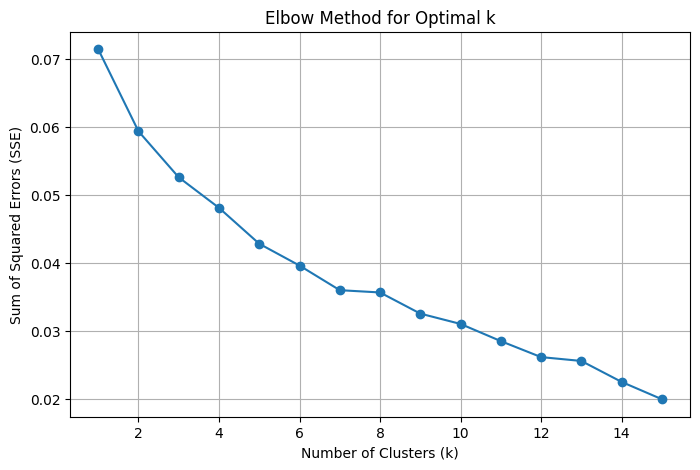

In [25]:
# List to store the SSE for each k
sse = []

# Range of cluster values to test 
k_range = range(1, 16)

# Compute KMeans and SSE for each value of k
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(trained_product_embeddings)
    sse.append(kmeans.inertia_)  # inertia_ is the SSE

# Plotting the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


In [26]:
from sklearn.cluster import KMeans

sse = {}
k_values = range(1, 16)  # You can change the upper limit as needed

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(trained_product_embeddings)
    sse[k] = kmeans.inertia_  # inertia_ is the SSE for that k

# Print the SSE scores
print("SSE Scores for each k:")
for k, score in sse.items():
    print(f"k = {k}: SSE = {score:.2f}")


SSE Scores for each k:
k = 1: SSE = 0.07
k = 2: SSE = 0.06
k = 3: SSE = 0.05
k = 4: SSE = 0.05
k = 5: SSE = 0.04
k = 6: SSE = 0.04
k = 7: SSE = 0.04
k = 8: SSE = 0.04
k = 9: SSE = 0.03
k = 10: SSE = 0.03
k = 11: SSE = 0.03
k = 12: SSE = 0.03
k = 13: SSE = 0.03
k = 14: SSE = 0.02
k = 15: SSE = 0.02


Based on the analysis, (for now) we will set the optimal number of clusters to be 6.

In [27]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(trained_product_embeddings)


In [28]:
# Print number of products in each cluster
for cluster in range(6):
    print("Cluster #{}".format(cluster))
    products = []
    # Find product indices belonging to the current cluster
    for prod_idx in np.where(kmeans.labels_ == cluster)[0]:
        prod_id = train_set.idx2productid[prod_idx]
        # Check how many times this product has been purchased
        purchase_count = len(merged_data.loc[merged_data['product_id'] == prod_id])
        products.append((product_names[prod_id], purchase_count))
    # Sort products by purchase count in descending order and print top 10
    for prod in sorted(products, key=lambda tup: tup[1], reverse=True)[:10]:
        print("\t", prod[0])

Cluster #0
	 RP Mahkota 50kg - Egypt
	 Dolomite M-100 50kg
	 NPK DGW 13-6-27 50kg
Cluster #1
	 Pupuk SawitPRO 20kg + Abu Janjang 40kg
	 RP Cap Daun 50Kg
	 NPK DGW 13-8-27-4 TE 50kg
	 Kapur Pertanian Kebomas 50 Kg
	 Marxone 300 SL - 5 Liter
	 Batara 135 SL - 1 Liter
	 Meroke Korn Kali B (KKB) 50kg
	 Bablass 490 SL - 1 Liter
	 NPK Mahkota 12-12-17-2 TE 50kg
	 DMA 6 825 SL 400ml
Cluster #2
	 MOP/KCL Canada Cap Mahkota 50kg
	 Urea Nitrea 46% N 50kg
	 Borate Mahkota - 25kg
	 Urea Nitrea 46% N 50kg - Granul
	 Paket Laporan Pengiriman
	 Meroke SS - AMMOPHOS 50kg
	 PRIMASTAR 300/100 SL 5 liter
Cluster #3
	 NPK Mahkota 13-8-27-4 0.5 B 50kg
	 Pupuk SawitPRO 50kg
	 TSP China Cap Daun 50kg
	 Petro ZA Plus 50kg
	 Token PLN 200.000
	 Token PLN 100.000
	 Kaos SIBRONDOL SawitPRO size XL
	 Meroke TSP 50kg
	 ZA Cap Daun 50Kg
	 Bibit Topaz Siap Tanam
Cluster #4
	 Pupuk SawitPRO 50kg + Abu Janjang 40kg
	 NPK Phonska Plus 15-15-15 25kg
	 Bablass 490 SL - 5 Liter
	 Dolomit Super Inti M-100 50kg
	 Mahkota ZA

Based on the user purchase frequency through KMeans, we group the products into clusters.
The output can be extracted and used in the front-end to use as a working recommendation system, where:
- When the user clicks on a product in the front-end pages, about 2 or 3 randomly-selected products from that identified cluster will be recommended to the user
- This will be labelled as "Frequently Bought Together"

##### Saving the Model

In [29]:
# Create a dictionary to store cluster results
cluster_products = {}

for cluster in range(6):
    products = []
    # Find product indices belonging to the current cluster
    for prod_idx in np.where(kmeans.labels_ == cluster)[0]:
        prod_id = train_set.idx2productid[prod_idx]
        # Check how many times this product has been purchased
        purchase_count = len(merged_data.loc[merged_data['product_id'] == prod_id])
        products.append({
            "product_id": prod_id,
            "product_name": product_names[prod_id],
            "purchase_count": purchase_count
        })
    # Sort products by purchase count in descending order and keep top 10
    products_sorted = sorted(products, key=lambda x: x["purchase_count"], reverse=True)[:10]
    cluster_products[cluster] = products_sorted

# Now cluster_products is a dictionary you can use in your API
# Example: cluster_products[0] gives the top products in cluster 0

# Optionally, to convert to JSON for API response:
import json
cluster_products_json = json.dumps(cluster_products)

##### Getting user input; Essential for API

( not tested yet )

In [33]:
def get_kmeans_user_recommendations(user_id, merged_data, train_set, kmeans, trained_product_embeddings, cluster_products, top_n=10):
    """
    Recommend top_n products for a user based on KMeans clusters of products they have purchased.
    """
    # Get unique product IDs the user has already purchased
    user_products = merged_data[merged_data['user_id'] == user_id]['product_id'].unique()
    recommended_products = []
    recommended_ids = set(user_products)  # To exclude already purchased

    for pid in user_products:
        # Map product_id to embedding index
        if pid not in train_set.productid2idx:
            continue  # skip if product not in index
        product_idx = train_set.productid2idx[pid]
        # Find the cluster for this product
        cluster = kmeans.predict(trained_product_embeddings[product_idx].reshape(1, -1))[0]
        # Get products from the same cluster, excluding already purchased
        for p in cluster_products[cluster]:
            if p["product_id"] not in recommended_ids:
                recommended_products.append(p)
                recommended_ids.add(p["product_id"])

    # Sort by purchase_count or any other metric you prefer
    recommended_products = sorted(recommended_products, key=lambda x: x["purchase_count"], reverse=True)
    # Get top N recommendations
    return recommended_products[:top_n]

# Example usage:
user_id = '13f5223e-f04a-4fa8-9ef2-cf36060f0d6d'
top_recommendations = get_kmeans_user_recommendations(
    user_id, merged_data, train_set, kmeans, trained_product_embeddings, cluster_products, top_n=10
)
print(f"Top 10 KMeans-based recommendations for user {user_id}:")
for rec in top_recommendations:
    print(f"{rec['product_name']} (Product ID: {rec['product_id']}) — Purchase Count: {rec['purchase_count']}")

Top 10 KMeans-based recommendations for user 13f5223e-f04a-4fa8-9ef2-cf36060f0d6d:
Urea Nitrea 46% N 50kg (Product ID: 4cac8d01-b78e-4017-9113-c627ac1866a5) — Purchase Count: 13
Borate Mahkota - 25kg (Product ID: a48adaed-ab06-4245-8da6-5d560636a1d9) — Purchase Count: 4
Urea Nitrea 46% N 50kg - Granul (Product ID: beb17fe4-5d92-4738-adaa-2d62ffb83516) — Purchase Count: 4
Dolomite M-100 50kg (Product ID: 9e7cc609-f4ef-4246-89e7-756861e623d8) — Purchase Count: 2
NPK DGW 13-6-27 50kg (Product ID: d3999f4e-890a-473f-bb92-2fd2178da3fb) — Purchase Count: 2
Paket Laporan Pengiriman (Product ID: c1d06ac3-5bea-4b4d-8648-ae3fa531f059) — Purchase Count: 1
Meroke SS - AMMOPHOS 50kg (Product ID: 8fcfd7a8-5980-4e7e-b463-6d30823caac4) — Purchase Count: 1
PRIMASTAR 300/100 SL 5 liter (Product ID: b67588d2-e8fe-4ee4-9931-e9d18241d04c) — Purchase Count: 1


In [35]:
def get_kmeans_recommendations(product_input, product_names, train_set, kmeans, trained_product_embeddings, cluster_products, top_n=3):
    """
    Recommend products from the same KMeans cluster as the input product.
    Accepts product_input as either product_id (UUID string) or product name.
    """
    # Helper: map product_input (name or id) to product_id (UUID string)
    def get_product_id_from_input(product_input, product_names):
        # If input matches a product_id directly
        if product_input in product_names:
            return product_input
        # If input matches a product name (case-insensitive)
        for pid, name in product_names.items():
            if name.lower() == str(product_input).lower():
                return pid
        return None

    product_id = get_product_id_from_input(product_input, product_names)
    if product_id is None:
        print("Product not found.")
        return []

    # Map product_id to embedding index
    if product_id not in train_set.productid2idx:
        print("Product ID not in training set.")
        return []
    product_idx = train_set.productid2idx[product_id]
    # Find the cluster for this product
    cluster = kmeans.predict(trained_product_embeddings[product_idx].reshape(1, -1))[0]

    # Recommend other products from the same cluster (excluding the input product)
    recommendations = [p for p in cluster_products[cluster] if p["product_id"] != product_id]
    print(f"Product '{product_names[product_id]}' (ID: {product_id}) is in cluster {cluster}.")
    print(f"Top {top_n} recommended products from the same cluster:")
    for rec in recommendations[:top_n]:
        print(f"- {rec['product_name']} (ID: {rec['product_id']})")
    return recommendations[:top_n]

# Example usage:
product_input = '80957603-6cec-4f63-8dcd-aba6ded5cbdd'  # or a product name
get_kmeans_recommendations(product_input, product_names, train_set, kmeans, trained_product_embeddings, cluster_products)

Product 'MOP/KCL Canada Cap Mahkota 50kg' (ID: 80957603-6cec-4f63-8dcd-aba6ded5cbdd) is in cluster 2.
Top 3 recommended products from the same cluster:
- Urea Nitrea 46% N 50kg (ID: 4cac8d01-b78e-4017-9113-c627ac1866a5)
- Borate Mahkota - 25kg (ID: a48adaed-ab06-4245-8da6-5d560636a1d9)
- Urea Nitrea 46% N 50kg - Granul (ID: beb17fe4-5d92-4738-adaa-2d62ffb83516)


[{'product_id': '4cac8d01-b78e-4017-9113-c627ac1866a5',
  'product_name': 'Urea Nitrea 46% N 50kg',
  'purchase_count': 13},
 {'product_id': 'a48adaed-ab06-4245-8da6-5d560636a1d9',
  'product_name': 'Borate Mahkota - 25kg',
  'purchase_count': 4},
 {'product_id': 'beb17fe4-5d92-4738-adaa-2d62ffb83516',
  'product_name': 'Urea Nitrea 46% N 50kg - Granul',
  'purchase_count': 4}]

In [36]:
# Define the user
user_id = '13f5223e-f04a-4fa8-9ef2-cf36060f0d6d'

# Get unique product IDs the user has already purchased
user_products = merged_data[merged_data['user_id'] == user_id]['product_id'].unique()

# Collect recommendations from clusters of all products the user has purchased
recommended_products = []
recommended_ids = set(user_products)  # To exclude already purchased

for pid in user_products:
    # Map product_id to embedding index
    if pid not in train_set.productid2idx:
        continue  # skip if product not in index
    product_idx = train_set.productid2idx[pid]
    # Find the cluster for this product
    cluster = kmeans.predict(trained_product_embeddings[product_idx].reshape(1, -1))[0]
    # Get products from the same cluster, excluding already purchased
    for p in cluster_products[cluster]:
        if p["product_id"] not in recommended_ids:
            recommended_products.append(p)
            recommended_ids.add(p["product_id"])

# Sort by purchase_count or any other metric you prefer
recommended_products = sorted(recommended_products, key=lambda x: x["purchase_count"], reverse=True)

# Get top 10 recommendations
top_n = 10
top_recommendations = recommended_products[:top_n]

# Display the recommendations
print(f"Top {top_n} KMeans-based recommendations for user {user_id}:")
for rec in top_recommendations:
    print(f"{rec['product_name']} (Product ID: {rec['product_id']}) — Purchase Count: {rec['purchase_count']}")

Top 10 KMeans-based recommendations for user 13f5223e-f04a-4fa8-9ef2-cf36060f0d6d:
Urea Nitrea 46% N 50kg (Product ID: 4cac8d01-b78e-4017-9113-c627ac1866a5) — Purchase Count: 13
Borate Mahkota - 25kg (Product ID: a48adaed-ab06-4245-8da6-5d560636a1d9) — Purchase Count: 4
Urea Nitrea 46% N 50kg - Granul (Product ID: beb17fe4-5d92-4738-adaa-2d62ffb83516) — Purchase Count: 4
Dolomite M-100 50kg (Product ID: 9e7cc609-f4ef-4246-89e7-756861e623d8) — Purchase Count: 2
NPK DGW 13-6-27 50kg (Product ID: d3999f4e-890a-473f-bb92-2fd2178da3fb) — Purchase Count: 2
Paket Laporan Pengiriman (Product ID: c1d06ac3-5bea-4b4d-8648-ae3fa531f059) — Purchase Count: 1
Meroke SS - AMMOPHOS 50kg (Product ID: 8fcfd7a8-5980-4e7e-b463-6d30823caac4) — Purchase Count: 1
PRIMASTAR 300/100 SL 5 liter (Product ID: b67588d2-e8fe-4ee4-9931-e9d18241d04c) — Purchase Count: 1


In [38]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Create user-product matrix
user_product_matrix = merged_data.pivot_table(index='user_id', columns='product_id', values='quantity', fill_value=0)

# Compute cosine similarity between items
item_similarity = cosine_similarity(user_product_matrix.T)
item_similarity_df = pd.DataFrame(item_similarity, index=user_product_matrix.columns, columns=user_product_matrix.columns)

def recommend_similar_items(product_id, item_similarity_df, merged_data, top_n=10):
    if product_id not in item_similarity_df.index:
        print(f"Product ID {product_id} not found.")
        return []

    # Get product name for the input product_id
    name_row = merged_data[merged_data['product_id'] == product_id]['name']
    input_product_name = name_row.iloc[0] if not name_row.empty else "Unknown"

    print(f"\nInput Product: {input_product_name} (Product ID: {product_id})")

    similar_items = item_similarity_df[product_id].sort_values(ascending=False)[1:top_n+1]

    print(f"Top {top_n} items similar to Product ID: {product_id}")
    for pid, score in similar_items.items():
        name = merged_data[merged_data['product_id'] == pid]['name'].iloc[0] \
            if not merged_data[merged_data['product_id'] == pid]['name'].empty else "Unknown"
        print(f"{name} — Similarity: {score:.4f}")

    return pd.DataFrame({
        'product_id': similar_items.index,
        'similarity': similar_items.values
    })

# Example usage
product_id = '80957603-6cec-4f63-8dcd-aba6ded5cbdd'  # replace with actual product_id
recommendations_df = recommend_similar_items(product_id, item_similarity_df, merged_data)



Input Product: MOP/KCL Canada Cap Mahkota 50kg (Product ID: 80957603-6cec-4f63-8dcd-aba6ded5cbdd)
Top 10 items similar to Product ID: 80957603-6cec-4f63-8dcd-aba6ded5cbdd
NPK Mahkota 13-8-27-4 0.5 B 50kg — Similarity: 0.3659
TSP China Cap Daun 50kg — Similarity: 0.1618
RP Mahkota 50kg - Egypt — Similarity: 0.1615
Urea Nitrea 46% N 50kg — Similarity: 0.1301
Meroke TSP 50kg — Similarity: 0.0971
Borate Mahkota - 25kg — Similarity: 0.0762
Kieserite SoluMAG-G 50kg — Similarity: 0.0024
Petro ZA Plus 50kg — Similarity: 0.0022
Pupuk SawitPRO 50kg — Similarity: 0.0003
RP Cap Daun 50Kg — Similarity: 0.0001


##### Saving the Model as JSON

In [30]:
# View the Python dictionary
print(cluster_products)

# View the JSON string (nicely formatted)
import json
print(json.dumps(cluster_products, indent=2))

{0: [{'product_id': 'beb17fe4-5d92-4738-adaa-2d62ffb83516', 'product_name': 'Urea Nitrea 46% N 50kg - Granul', 'purchase_count': 4}, {'product_id': '9e7cc609-f4ef-4246-89e7-756861e623d8', 'product_name': 'Dolomite M-100 50kg', 'purchase_count': 2}, {'product_id': '8fcfd7a8-5980-4e7e-b463-6d30823caac4', 'product_name': 'Meroke SS - AMMOPHOS 50kg', 'purchase_count': 1}, {'product_id': '487f2886-5150-4269-94e2-63fbc7314971', 'product_name': 'Bibit Topaz Siap Tanam', 'purchase_count': 1}, {'product_id': '944f4171-813b-4423-ad89-3c73d67f9986', 'product_name': 'NPK Sawit 13-8-27-4 0.5 B Pak Tani 50kg', 'purchase_count': 1}], 1: [{'product_id': '4cac8d01-b78e-4017-9113-c627ac1866a5', 'product_name': 'Urea Nitrea 46% N 50kg', 'purchase_count': 13}, {'product_id': 'b53ce31c-3789-42d7-96a0-5fe058cac7a5', 'product_name': 'RP Mahkota 50kg - Egypt', 'purchase_count': 7}, {'product_id': '6c27fc9c-e7e9-4e9b-9017-292175250df1', 'product_name': 'NPK Phonska Plus 15-15-15 25kg', 'purchase_count': 4}, {'

In [31]:
# Test: view just the first cluster
print(cluster_products[0])

[{'product_id': 'beb17fe4-5d92-4738-adaa-2d62ffb83516', 'product_name': 'Urea Nitrea 46% N 50kg - Granul', 'purchase_count': 4}, {'product_id': '9e7cc609-f4ef-4246-89e7-756861e623d8', 'product_name': 'Dolomite M-100 50kg', 'purchase_count': 2}, {'product_id': '8fcfd7a8-5980-4e7e-b463-6d30823caac4', 'product_name': 'Meroke SS - AMMOPHOS 50kg', 'purchase_count': 1}, {'product_id': '487f2886-5150-4269-94e2-63fbc7314971', 'product_name': 'Bibit Topaz Siap Tanam', 'purchase_count': 1}, {'product_id': '944f4171-813b-4423-ad89-3c73d67f9986', 'product_name': 'NPK Sawit 13-8-27-4 0.5 B Pak Tani 50kg', 'purchase_count': 1}]


In [32]:
# Test: view just the first cluster in JSON format
print(json.dumps(cluster_products[0], indent=2))

[
  {
    "product_id": "beb17fe4-5d92-4738-adaa-2d62ffb83516",
    "product_name": "Urea Nitrea 46% N 50kg - Granul",
    "purchase_count": 4
  },
  {
    "product_id": "9e7cc609-f4ef-4246-89e7-756861e623d8",
    "product_name": "Dolomite M-100 50kg",
    "purchase_count": 2
  },
  {
    "product_id": "8fcfd7a8-5980-4e7e-b463-6d30823caac4",
    "product_name": "Meroke SS - AMMOPHOS 50kg",
    "purchase_count": 1
  },
  {
    "product_id": "487f2886-5150-4269-94e2-63fbc7314971",
    "product_name": "Bibit Topaz Siap Tanam",
    "purchase_count": 1
  },
  {
    "product_id": "944f4171-813b-4423-ad89-3c73d67f9986",
    "product_name": "NPK Sawit 13-8-27-4 0.5 B Pak Tani 50kg",
    "purchase_count": 1
  }
]


##### Export model to use for API

In [34]:
# Option 1: Using joblib (preferred for sklearn models)
import joblib

# Save the KMeans clustering model (make sure 'kmeans' is your fitted model variable)
joblib.dump(kmeans, 'kmeans_model.pkl')

# To load the model later:
# kmeans_loaded = joblib.load('kmeans_model.pkl')

['kmeans_model.pkl']

### A/B Testing using EconML

#### How EconML A/B testing works
---

##### **1. The Problem**
- In a typical A/B test, you randomly assign users to a treatment (e.g., new feature) or control group.
- But sometimes, **not everyone assigned to the treatment actually takes it** (e.g., not everyone offered a new signup actually signs up).
- This “imperfect compliance” means you can’t just compare the two groups directly, because the groups are now mixed.

---

##### **2. The Solution: Instrumental Variables (IV)**
- **EconML** uses **instrumental variable (IV) methods** to estimate the *true causal effect* of the treatment, even when compliance is imperfect.
- In your example, the “nudge” (easier signup) is the **instrument** (Z), the actual action (became member) is the **treatment** (T), and the outcome (days visited after) is **Y**.

---

##### **3. How EconML Works**
- **Step 1:** Model how the instrument (Z) affects the treatment (T), and how the features (X) affect the outcome (Y).
- **Step 2:** Use machine learning models (like LightGBM or Random Forest) to estimate these relationships.
- **Step 3:** Combine these models to estimate the *causal effect* of the treatment (T) on the outcome (Y), using the random assignment (Z) as a source of unbiased variation.

---

##### **4. Why This Works**
- The random assignment (Z) is not affected by user behavior, so it provides a “clean” source of variation.
- By focusing on the part of T that is explained by Z, EconML can estimate what would have happened if everyone had taken the treatment, not just those who chose to.

---

##### **5. What You Get**
- **Average Treatment Effect:** How much the treatment changes the outcome, on average.
- **Heterogeneous Effects:** How the effect varies for different types of users (using their features X).
- **Policy Recommendations:** Who should get the treatment to maximize benefit.

---

**In summary:**  
EconML lets you estimate the *true causal effect* of a treatment in A/B tests, even when not everyone follows their assignment, by using advanced statistical and machine learning techniques.

In [35]:
# View dataset before it got fit into KMeans
merged_data.head()

,sale_order_item_id,sale_order_id,product_id,quantity,sale_order_item_price,clicked_from_recommendation,click_timestamp,user_id,total_item_price,created_at_utc0,sku,type,unit_of_measurement,name,product_price,description
0,7eefa7db-26bf-4a8b-b207-f44a52ed0aba,3ddca641-cb59-4a27-8698-cb16ff2932f2,b53ce31c-3789-42d7-96a0-5fe058cac7a5,200,125000.0,False,NaT,13f5223e-f04a-4fa8-9ef2-cf36060f0d6d,90200000.0,1744078798583,101110502101,GOODS,kg,RP Mahkota 50kg - Egypt,352688.0,"Rock Phosphate (RP) adalah salah satu sumber fosfat terbaik di dunia yang diolah secara efisien tanpa proses kimia. DeskripsiPupuk RP Mesir adalah pupuk yang diproses dari bahan baku galian yang mengandung mineral kalsium fosfat, yang berasal dari batuan yang diolah menjadi bubuk (powder) untuk digunakan langsung dalam pertanian. Pupuk ini dapat diterapkan dalam bentuk bubuk, butiran, atau granular.ManfaatMemberikan unsur fosfor alami yang dibutuhkan tanaman, mendukung perkembangan akar dan batang, meningkatkan kualitas akar serta batang tanaman, memperbaiki kemampuan tanaman dalam menyerap air dan nutrisi, serta melindungi tanaman dari serangan hama.Kandungan dan SpesifikasiFosfor pentoksida 26-28%Produk Teruji Lab? Ya"
1,e9b32dc3-4e0f-4a69-bb3d-c7f11277f97f,787bc8b7-e679-4772-be5d-af4afac9adf5,5952d124-7dc6-4a6a-baa2-e2e502ecd6fe,1,109000.0,False,NaT,1e75f22f-b609-4ebc-9536-4a26aef73302,109000.0,1744182202966,TUP/PLN/100,DIGITAL,,Token PLN 100.000,109000.0,Topup PLN 100.000 Topup PLN 100.000
2,86a41dec-9936-4c8f-9150-e8b367a4959f,4d47dd32-1618-4376-a846-66bcf065e173,0bd2430a-6613-442a-9d5a-11d64cb095ae,1,65000.0,False,NaT,344963f8-9a3a-4de3-b3a9-c8716fa37c0e,65000.0,1742438712361,MERCH-SAWITPRO-SHIRT-02,GOODS,kg,Kaos SIBRONDOL SawitPRO size XL,100000.0,"Kaos tidak berkerah warna Putih bertuliskan ""Sibrondol SawitPRO"".Ukuran All-size (XL)"
3,61cf5f3f-2a24-4080-bc4f-50af3506479d,e5819416-6b56-4337-9271-dc2c701ac7bd,80957603-6cec-4f63-8dcd-aba6ded5cbdd,2,688750.0,False,NaT,49ad56f8-8d32-408f-9f88-36cad5310680,1377500.0,1744874598061,101110501601,GOODS,kg,MOP/KCL Canada Cap Mahkota 50kg,712500.0,"Pupuk MOP/KCL untuk meningkatkan Kualitas dan Kuantitas Buah. DeskripsiPupuk MOP/KCL Mahkota mengandung kalium (K2O) minimal 60% dan berguna untuk membantu meningkatkan hasil dan kualitas panen. Pupuk ini juga mengoptimalkan penyerapan unsur hara lainnya dan meningkatkan ketahanan tanaman terhadap hama dan penyakit. Penggunaan KCL sangat penting untuk tanaman tahunan yang membutuhkan kalium tinggi.Manfaat Pupuk kalium oksida (K2O) meningkatkan pertumbuhan dan hasil tanaman dengan menyuplai kalium yang penting untuk daya tahan tanaman terhadap stres, serta mendukung pembentukan buah, bunga, dan umbi. Pupuk ini juga memperbaiki kualitas hasil panen dan efisiensi penggunaan air serta nutrisi, menjadikannya bermanfaat untuk tanaman yang membutuhkan kalium tinggi, seperti padi, jagung, dan tanaman hortikultura.Kandungan dan Spesifikasi Kalium oksida 60%Bentuk / Warna: Kristal / Dominan merahProduk Teruji Lab? Ya"
4,4ebafa85-bc91-4685-9775-3cc06be3f4b6,a1688ca7-4123-4d2a-8ef4-44a0be1580a1,6c27fc9c-e7e9-4e9b-9017-292175250df1,90,219125.0,False,NaT,41bec98e-b466-496b-acf2-e993389ac42b,19721250.0,1742714745447,101110603901,GOODS,kg,NPK Phonska Plus 15-15-15 25kg,441142.0,"Tingkatkan pertumbuhan dengan zinc 2000ppm dan sulfur 9%. DeskripsiPupuk majemuk NPK yang diperkaya dengan unsur sulfur dan zinc ini dirancang untuk meningkatkan efisiensi dan efektivitas pemupukan. Kandungan sulfur dan zinc tersebut mendukung proses metabolisme tanaman sehingga tidak hanya meningkatkan jumlah hasil panen, tetapi juga kualitasnya, membuat tanaman lebih sehat dan produktif.Bentuk / Warna: Granul / PutihManfaatPupuk ini mendukung pertumbuhan tanaman, meningkatkan hasil, dan kualitas tanaman dengan memperkuat metabolisme, pembelahan sel, serta pembentukan enzim dan vitamin. Selain itu, juga merangsang pertumbuhan akar dan daun serta meningkatkan imunitas tanaman.Kandungan dan SpesifikasiNitrogen 

#### Add assignment column
This is to indicate which group each user is in

In [36]:
# Clone the DataFrame
ab_test_data = merged_data.copy()

# Assign each user randomly to control (0) or treatment (1)
user_ids = ab_test_data['user_id'].unique()
np.random.seed(42)
assignments = np.random.choice([0, 1], size=len(user_ids))
user_assignment = dict(zip(user_ids, assignments))

ab_test_data['assignment'] = ab_test_data['user_id'].map(user_assignment)

# ab_test_data now has the assignment column for A/B testing
ab_test_data.head()

,sale_order_item_id,sale_order_id,product_id,quantity,sale_order_item_price,clicked_from_recommendation,click_timestamp,user_id,total_item_price,created_at_utc0,sku,type,unit_of_measurement,name,product_price,description,assignment
0,7eefa7db-26bf-4a8b-b207-f44a52ed0aba,3ddca641-cb59-4a27-8698-cb16ff2932f2,b53ce31c-3789-42d7-96a0-5fe058cac7a5,200,125000.0,False,NaT,13f5223e-f04a-4fa8-9ef2-cf36060f0d6d,90200000.0,1744078798583,101110502101,GOODS,kg,RP Mahkota 50kg - Egypt,352688.0,"Rock Phosphate (RP) adalah salah satu sumber fosfat terbaik di dunia yang diolah secara efisien tanpa proses kimia. DeskripsiPupuk RP Mesir adalah pupuk yang diproses dari bahan baku galian yang mengandung mineral kalsium fosfat, yang berasal dari batuan yang diolah menjadi bubuk (powder) untuk digunakan langsung dalam pertanian. Pupuk ini dapat diterapkan dalam bentuk bubuk, butiran, atau granular.ManfaatMemberikan unsur fosfor alami yang dibutuhkan tanaman, mendukung perkembangan akar dan batang, meningkatkan kualitas akar serta batang tanaman, memperbaiki kemampuan tanaman dalam menyerap air dan nutrisi, serta melindungi tanaman dari serangan hama.Kandungan dan SpesifikasiFosfor pentoksida 26-28%Produk Teruji Lab? Ya",0
1,e9b32dc3-4e0f-4a69-bb3d-c7f11277f97f,787bc8b7-e679-4772-be5d-af4afac9adf5,5952d124-7dc6-4a6a-baa2-e2e502ecd6fe,1,109000.0,False,NaT,1e75f22f-b609-4ebc-9536-4a26aef73302,109000.0,1744182202966,TUP/PLN/100,DIGITAL,,Token PLN 100.000,109000.0,Topup PLN 100.000 Topup PLN 100.000,1
2,86a41dec-9936-4c8f-9150-e8b367a4959f,4d47dd32-1618-4376-a846-66bcf065e173,0bd2430a-6613-442a-9d5a-11d64cb095ae,1,65000.0,False,NaT,344963f8-9a3a-4de3-b3a9-c8716fa37c0e,65000.0,1742438712361,MERCH-SAWITPRO-SHIRT-02,GOODS,kg,Kaos SIBRONDOL SawitPRO size XL,100000.0,"Kaos tidak berkerah warna Putih bertuliskan ""Sibrondol SawitPRO"".Ukuran All-size (XL)",0
3,61cf5f3f-2a24-4080-bc4f-50af3506479d,e5819416-6b56-4337-9271-dc2c701ac7bd,80957603-6cec-4f63-8dcd-aba6ded5cbdd,2,688750.0,False,NaT,49ad56f8-8d32-408f-9f88-36cad5310680,1377500.0,1744874598061,101110501601,GOODS,kg,MOP/KCL Canada Cap Mahkota 50kg,712500.0,"Pupuk MOP/KCL untuk meningkatkan Kualitas dan Kuantitas Buah. DeskripsiPupuk MOP/KCL Mahkota mengandung kalium (K2O) minimal 60% dan berguna untuk membantu meningkatkan hasil dan kualitas panen. Pupuk ini juga mengoptimalkan penyerapan unsur hara lainnya dan meningkatkan ketahanan tanaman terhadap hama dan penyakit. Penggunaan KCL sangat penting untuk tanaman tahunan yang membutuhkan kalium tinggi.Manfaat Pupuk kalium oksida (K2O) meningkatkan pertumbuhan dan hasil tanaman dengan menyuplai kalium yang penting untuk daya tahan tanaman terhadap stres, serta mendukung pembentukan buah, bunga, dan umbi. Pupuk ini juga memperbaiki kualitas hasil panen dan efisiensi penggunaan air serta nutrisi, menjadikannya bermanfaat untuk tanaman yang membutuhkan kalium tinggi, seperti padi, jagung, dan tanaman hortikultura.Kandungan dan Spesifikasi Kalium oksida 60%Bentuk / Warna: Kristal / Dominan merahProduk Teruji Lab? Ya",0
4,4ebafa85-bc91-4685-9775-3cc06be3f4b6,a1688ca7-4123-4d2a-8ef4-44a0be1580a1,6c27fc9c-e7e9-4e9b-9017-292175250df1,90,219125.0,False,NaT,41bec98e-b466-496b-acf2-e993389ac42b,19721250.0,1742714745447,101110603901,GOODS,kg,NPK Phonska Plus 15-15-15 25kg,441142.0,"Tingkatkan pertumbuhan dengan zinc 2000ppm dan sulfur 9%. DeskripsiPupuk majemuk NPK yang diperkaya dengan unsur sulfur dan zinc ini dirancang untuk meningkatkan efisiensi dan efektivitas pemupukan. Kandungan sulfur dan zinc tersebut mendukung proses metabolisme tanaman sehingga tidak hanya meningkatkan jumlah hasil panen, tetapi juga kualitasnya, membuat tanaman lebih sehat dan produktif.Bentuk / Warna: Granul / PutihManfaatPupuk ini mendukung pertumbuhan tanaman, meningkatkan hasil, dan kualitas tanaman dengan memperkuat metabolisme, pembelahan sel, serta pembentukan enzim dan vitamin. Selain itu, juga merangsang pertumbuhan akar dan daun serta meningkatkan imunitas tanaman.Kandungan dan S

#### Define outcome (V)
Decide what you want to measure as the effect of the recommendation system

Common choices:
- total quantity purchased per user
- total revenue earned form each user 
- number of unique products purchased
- clicks on recommendations (true/false)

Example chosen: Total quanitty purchased per year

In [37]:
# Aggregate outcome per user
user_outcomes = ab_test_data.groupby('user_id').agg({
    'quantity': 'sum',           # total quantity purchased
    'assignment': 'first'        # group assignment
    # Add more features here if needed
}).reset_index()

#### Adding user features (X) (optional)
This is done to estimate heterogeneous effects (how different users respond); We do this by adding user-level features. Some choices to consider:
- user's area, farm, or previous purchase count
- any other demographic or behavioural features

Example: number of unique products purchased as a feature

In [38]:
# Example: add number of unique products purchased as a feature
user_outcomes['unique_products'] = ab_test_data.groupby('user_id')['product_id'].nunique().values

In [39]:
# view it
user_outcomes.head(100)

,user_id,quantity,assignment,unique_products
0,02b2724f-0227-4c94-a7a0-8cf37f7aee70,5,0,1
1,05dfbe78-f1f3-486d-8bc8-91ef41b3ae78,25,0,1
2,05ebeca1-5a73-46ec-88fc-323b29d468cc,200,0,1
3,0600fab5-173c-4333-b3c3-c18b37148acf,200,0,1
4,0baaaa63-a05f-492d-8f87-9532257d85f9,200,0,1
...,...,...,...,...
68,ebd171b6-81b8-43f2-afa2-67c5db13845a,323,0,4
69,ec22c8d8-8647-4c0d-8ace-63be2bbe57a0,1,1,1
70,ecc640f2-61b3-41e4-b2c5-5cd2421da2d8,55,0,1
71,eddc7f2d-9b65-477d-8014-65a332d93f37,150,0,1


In [40]:
user_outcomes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   user_id          73 non-null     object
 1   quantity         73 non-null     int64 
 2   assignment       73 non-null     int32 
 3   unique_products  73 non-null     int64 
dtypes: int32(1), int64(2), object(1)
memory usage: 2.1+ KB


#### Prepare data for EconML 
setting up the variables:
- Z: Assignment (from `user_outcomes['assignment']`)
- Y: Outcomes (from `user_outcomes['quantity']` or your other chosen metric)
- X: User features (optional, e.g., `user_outcomes[['unique_products']]`)

In [41]:
Z = user_outcomes['assignment']
Y = user_outcomes['quantity']
X = user_outcomes[['unique_products']]  # or add more features if you have them

# If you do NOT have a separate treatment variable (imperfect compliance), set:
T = Z  # everyone assigned to treatment receives it

##### Define Nuisance Models using LightGBM
The model requires to define some nuissance models (i.e. models we don't really care about but that matter for the analysis): the model for how the outcome $Y$ depends on the features $X$ (`model_Y_X`) and the model for how the treatment $T$ depends on the instrument $Z$ and features $X$ (`model_T_XZ`). For instance, we can use generic boosted tree estimators to learn them. 

In [42]:
import lightgbm as lgb
from sklearn.preprocessing import PolynomialFeatures

lgb_T_XZ_params = {
    'objective' : 'binary',
    'metric' : 'auc',
    'learning_rate': 0.1,
    'num_leaves' : 30,
    'max_depth' : 5
}

lgb_Y_X_params = {
    'metric' : 'rmse',
    'learning_rate': 0.1,
    'num_leaves' : 30,
    'max_depth' : 5
}
model_T_XZ = lgb.LGBMClassifier(**lgb_T_XZ_params)
model_Y_X = lgb.LGBMRegressor(**lgb_Y_X_params)
flexible_model_effect = lgb.LGBMRegressor(**lgb_Y_X_params)

#### Fit EconML Model

In [43]:
from econml.iv.dr import LinearIntentToTreatDRIV

model = LinearIntentToTreatDRIV(
    model_y_xw = model_Y_X,
    model_t_xwz = model_T_XZ,
    flexible_model_effect = flexible_model_effect,
    featurizer = PolynomialFeatures(degree=1, include_bias=False)
)
model.fit(Y, T, Z=Z, X=X, inference="statsmodels")

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 73, number of used features: 0
[LightGBM] [Info] Start training from score 162.136986
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the sp

##### Interpret Results

In [44]:
# Compare learned coefficients with true model coefficients
coef_indices = np.arange(model.coef_.shape[0])
# Calculate error bars
coef_error = np.asarray(model.coef__interval()) # 95% confidence interval for coefficients
coef_error[0, :] = model.coef_ - coef_error[0, :]
coef_error[1, :] = coef_error[1, :] - model.coef_

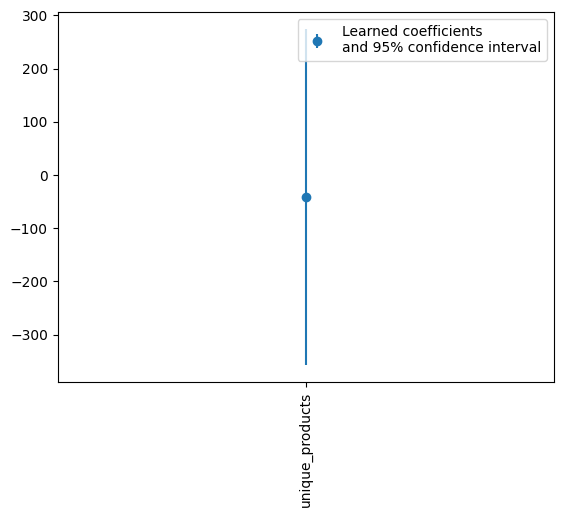

In [45]:
# Plot learned coefficients (if using a linear featurizer)
coef_indices = np.arange(model.coef_.shape[0])
coef_error = np.asarray(model.coef__interval())
coef_error[0, :] = model.coef_ - coef_error[0, :]
coef_error[1, :] = coef_error[1, :] - model.coef_
plt.errorbar(coef_indices, model.coef_, coef_error, fmt="o", label="Learned coefficients\nand 95% confidence interval")
plt.xticks(coef_indices, X.columns, rotation='vertical')
plt.legend()
plt.show()

In [46]:
model.summary()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
unique_products,-41.817,161.063,-0.26,0.795,-357.494,273.861
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,57.921,149.321,0.388,0.698,-234.744,350.585


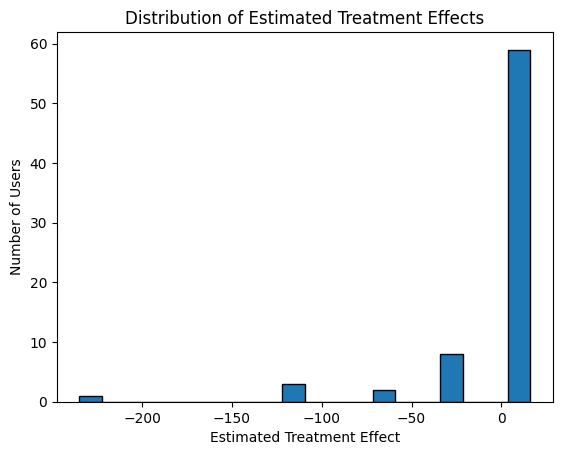

In [47]:
# Visualize the distribution of estimated treatment effects for your users
treatment_effects = model.effect(X)
plt.hist(treatment_effects, bins=20, edgecolor='k')
plt.xlabel("Estimated Treatment Effect")
plt.ylabel("Number of Users")
plt.title("Distribution of Estimated Treatment Effects")
plt.show()

##### Understanding Treatment Effects
EconML includes interpretability tools to better understand treatment effects. Treatment effects can be complex, but oftentimes we are interested in simple rules that can differentiate between users who respond positively, users who remain neutral and users who respond negatively to the proposed changes.

The EconML `SingleTreeCateInterpreter` provides interperetability by training a single decision tree on the treatment effects outputted by the any of the EconML estimators. In the figure below we can see in dark red users who respond negatively to the membership program and in dark green users who respond positively.

X has feature names, but PolynomialFeatures was fitted without feature names
X has feature names, but PolynomialFeatures was fitted without feature names
X has feature names, but PolynomialFeatures was fitted without feature names
X has feature names, but PolynomialFeatures was fitted without feature names


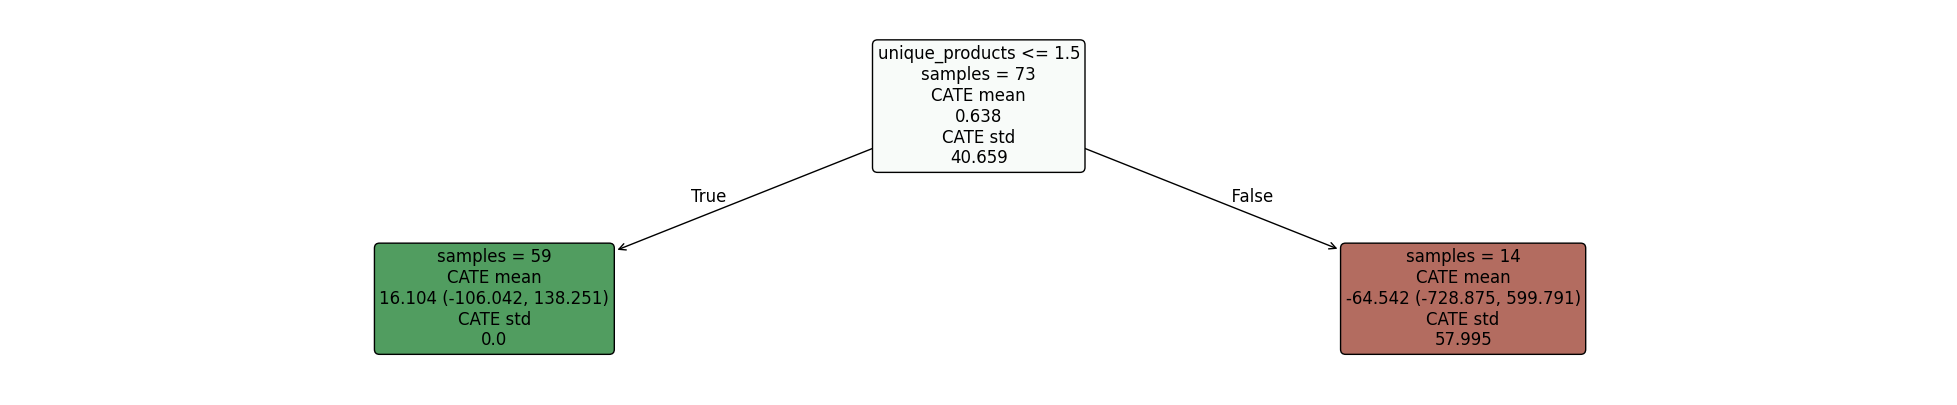

In [48]:
from econml.cate_interpreter import SingleTreeCateInterpreter

intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=2, min_samples_leaf=10)
intrp.interpret(model, X)
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=X.columns, fontsize=12)

##### Making policy decisions
Interventions usually have a cost: incetivizing a user to become a member can be costly (e.g by offering a discount). Thus, we would like to know what customers to target to maximize the profit from their increased engagement. This is the **treatment policy**. 

The EconML library includes policy interpretability tools such as `SingleTreePolicyInterpreter` that take in a treatment cost and the treatment effects to learn simple rules about which customers to target profitably. 

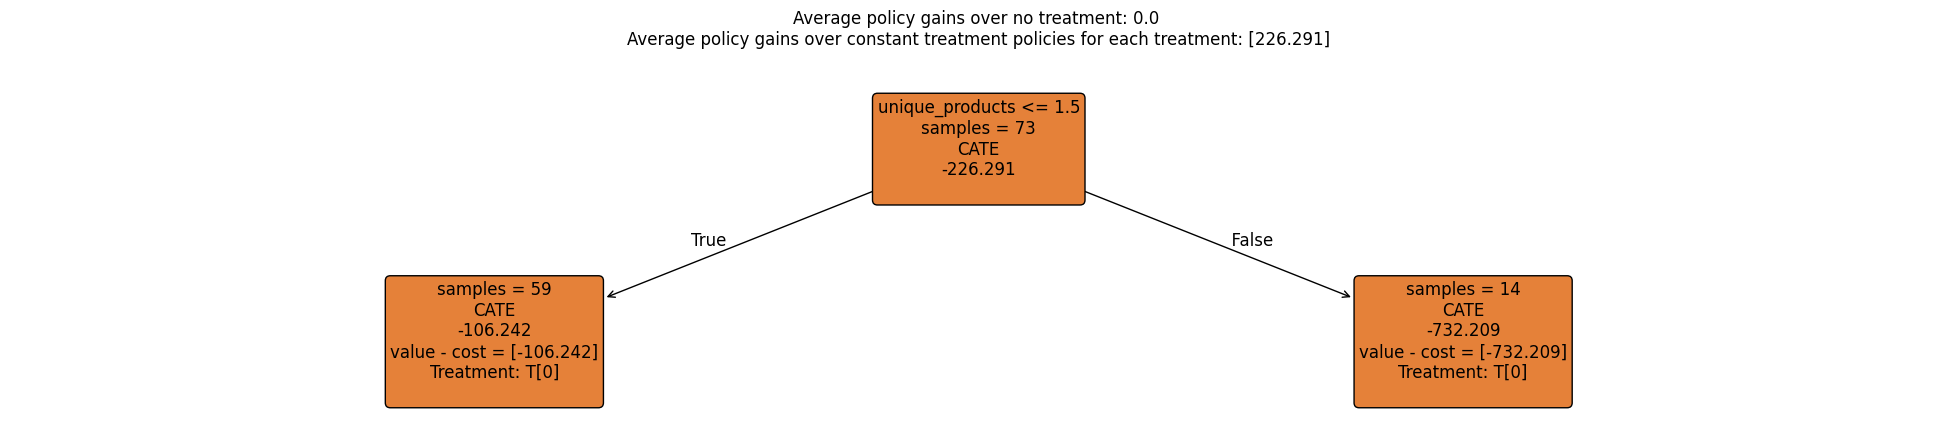

In [49]:
from econml.cate_interpreter import SingleTreePolicyInterpreter

intrp = SingleTreePolicyInterpreter(risk_level=0.05, max_depth=2, min_samples_leaf=10)
intrp.interpret(model, X, sample_treatment_costs=0.2)  # Use your X and a treatment cost (e.g., 0.2)
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=X.columns, fontsize=12)

##### Interpreting the model with ATE
ATE tells the average casual effect of the treatment (e.g, being assigned to the new recommender system) on the outcome (e.g., quantity purchased) across all users

In [50]:
# Calculate the Average Treatment Effect (ATE)
ate = model.ate(X)
print("Average Treatment Effect (ATE):", ate)

Average Treatment Effect (ATE): 0.6377911938089487


Based on the ATE, we can predict that on average, **users exposed to this KMeans recommendations system tend to buy ~3x buy more products, as compared to users not exposed to the recommendation system

In [51]:
# 95% confidence interval for the ATE
ate_interval = model.ate_interval(X)
print("95% confidence interval for ATE:", ate_interval)

95% confidence interval for ATE: (-197.47407230543308, 198.74965469305093)


The **confidence interval** for the ATE tells you the range in which the *true* average treatment effect is likely to fall, with a certain level of confidence (usually 95%).

Suppose your output is:
```
95% confidence interval for ATE: (2.1, 5.3)
```

**How to read this:**
- You are 95% confident that the *true* average treatment effect is **between 2.1 and 5.3**.
- If the interval **does not include 0**, the effect is statistically significant (the treatment likely has a real effect).
- If the interval **includes 0** (e.g., `(-1.2, 2.5)`), the effect might not be significant.

**Summary:**  
- **Entirely above 0:** Treatment increases the outcome (significant positive effect).
- **Entirely below 0:** Treatment decreases the outcome (significant negative effect).
- **Includes 0:** No statistically significant effect detected.

##### **How to read the average treatment effect (ATE)?**

- The **ATE** is the estimated difference in your outcome (e.g., total quantity purchased) **caused by** being in the treatment group (seeing the new recommender) versus the control group (not seeing it).
- **If ATE > 0:** On average, users in the treatment group bought more than those in control.
- **If ATE < 0:** The treatment group bought less.
- **If ATE ≈ 0:** No significant effect from the new recommender.

---

##### **What does it mean?**

- The ATE tells you **how much impact** your new recommendation system has on user behavior, after accounting for random assignment and any confounding factors.
- **Example:** If ATE = 2.5, then users exposed to the new system bought, on average, 2.5 more items than those who were not.

---

##### **How can I improve the model?**

1. **Add more user features (X):**  
   Include demographics, past purchase behavior, or engagement metrics to estimate heterogeneous effects (how different users respond).
2. **Use a richer outcome (Y):**  
   Try revenue, click-through rate, or other business KPIs.
3. **Track actual exposure (T):**  
   If not all assigned users actually see/interact with the new system, track this and use it as the treatment variable.
4. **Try different machine learning models:**  
   Use more advanced models for `model_y_xw` and `model_t_xwz` (e.g., GradientBoosting, LightGBM).
5. **Increase sample size:**  
   More users = more statistical power.

---

**In summary:**  
The ATE tells you the real-world impact of your new recommender. EconML helps you estimate this causally, not just correlationally. You can improve by adding more features, using better models, and tracking more detailed outcomes.